In [10]:
import kagglehub
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fake-and-real-news-dataset


In [11]:
import pandas as pd
fake = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')
real = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
fake["label"] = 1
real["label"] = 0
df = pd.concat([fake, real], ignore_index=True)  #concat the fake and real
df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [12]:
#Custom Tokenizer
import re

def custom_tokenizer(text):
    text = text.lower()  # Normalize case
    # function to collapse repeated characters
    def collapse(word):
        return re.sub(r'(.)\1{2,}', lambda m: f"{m.group(1)} <REPEAT:{len(m.group(0))}>", word)

    tokens = []
    for word in text.split():
        word = collapse(word)
        word = re.sub(r'([!?.,;:])', r' \1 ', word)
        tokens.extend(word.split())
    return tokens

In [13]:
#POS Tagging
def pos_tag(tokens):
    pos_tags = []
    for word in tokens:
        if re.match(r'.*ing$', word):  # words ending in 'ing' are verbs
            pos_tags.append((word, 'VERB'))
        elif re.match(r'.*ly$', word):  # words ending in 'ly' are adverbs
            pos_tags.append((word, 'ADV'))
        elif word in ['a', 'the', 'in', 'on']:  # articles & prepositions
            pos_tags.append((word, 'DET'))
        elif word in ['so', 'unbelievable', 'shocking']:  # adjectives
            pos_tags.append((word, 'ADJ'))
        else:
            pos_tags.append((word, 'NOUN'))
    return pos_tags

tokens = custom_tokenizer("Soooo shocking!!! Doctors STUNNED!!")
print(pos_tag(tokens))

[('so', 'ADJ'), ('<REPEAT', 'NOUN'), (':', 'NOUN'), ('4>', 'NOUN'), ('shocking', 'VERB'), ('!', 'NOUN'), ('<REPEAT', 'NOUN'), (':', 'NOUN'), ('3>', 'NOUN'), ('doctors', 'NOUN'), ('stunned', 'NOUN'), ('!', 'NOUN'), ('!', 'NOUN')]


In [14]:
def lemmatize(tokens, pos_tags):
    lemmatized_tokens = []

    irregular_verbs = {
        'ran': 'run',
        'went': 'go',
        'did': 'do',
        'has': 'have',
        'had': 'have',
        'stunned': 'stun',
        'shocked': 'shock',
    }

    for word, pos in pos_tags:
        if pos == 'VERB':
            if word in irregular_verbs:
                lemmatized_tokens.append(irregular_verbs[word])
            elif word.endswith('ing'):
                lemmatized_tokens.append(word[:-3])
            elif word.endswith('ed'):
                lemmatized_tokens.append(word[:-2])
            else:
                lemmatized_tokens.append(word)
        elif pos == 'NOUN':
            if word.endswith('s') and len(word) > 3:
                lemmatized_tokens.append(word[:-1])
            else:
                lemmatized_tokens.append(word)
        else:
            lemmatized_tokens.append(word)

    return lemmatized_tokens

In [15]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer


cleaned_text = df['title'].apply(lambda x: ' '.join(lemmatize(pos_tag(custom_tokenizer(x)), pos_tag(custom_tokenizer(x)))))

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(cleaned_text)

# Labels (Real=0, Fake=1)
y = df['label']

print(X.shape)


(44898, 5000)


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Naive Bayes Classifier
nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)

# SVM Classifier
svm = SVC()
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

print("Naive Bayes Classifier Metrics:")
print(classification_report(y_test, y_pred_nb))
print(confusion_matrix(y_test, y_pred_nb))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))

print("\nSVM Classifier Metrics:")
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))


Naive Bayes Classifier Metrics:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      4247
           1       0.93      0.95      0.94      4733

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980

[[3896  351]
 [ 223 4510]]
Accuracy: 0.9360801781737194

SVM Classifier Metrics:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      4247
           1       0.97      0.96      0.96      4733

    accuracy                           0.96      8980
   macro avg       0.96      0.96      0.96      8980
weighted avg       0.96      0.96      0.96      8980

[[4095  152]
 [ 195 4538]]
Accuracy: 0.961358574610245


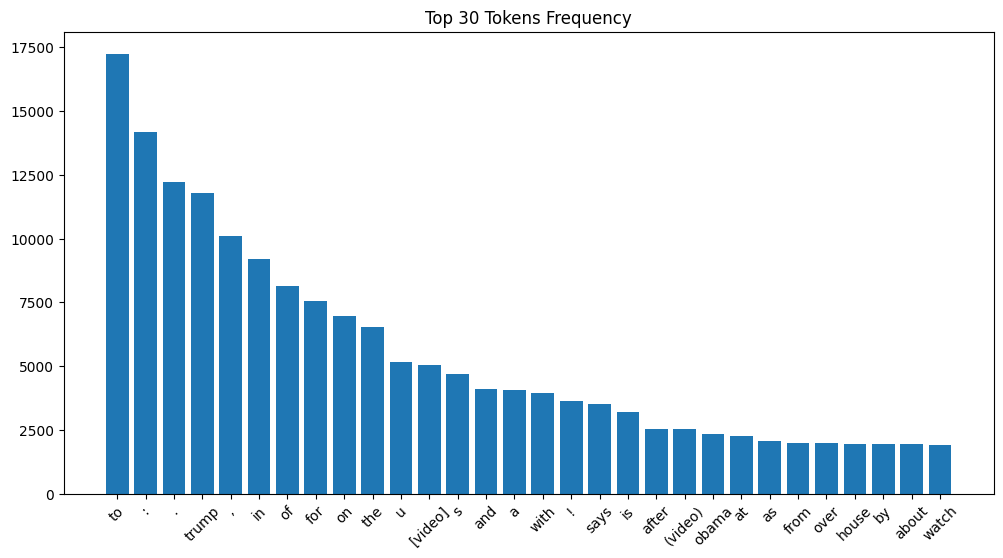

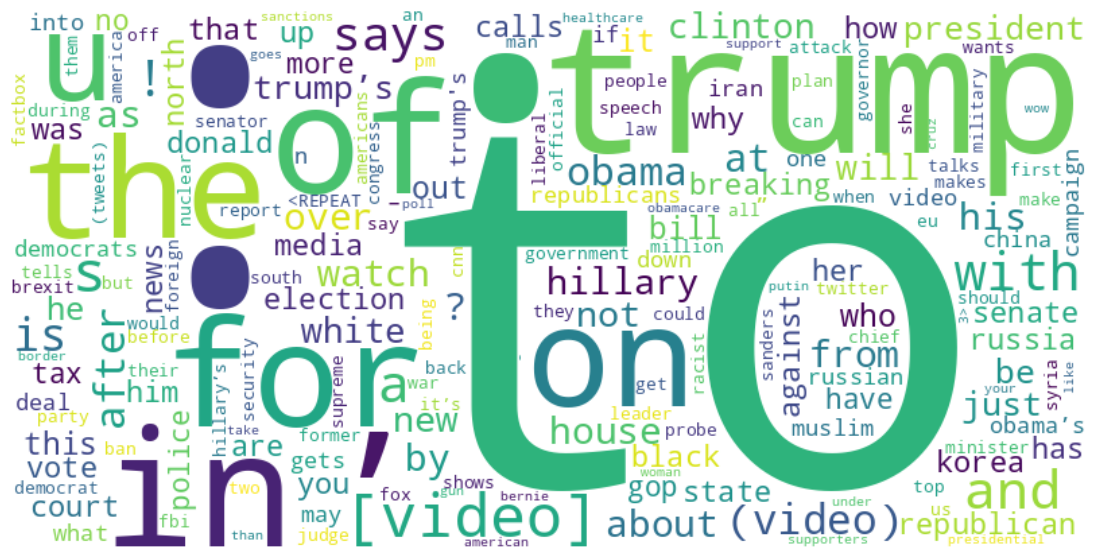

No <REPEAT:n> tokens found in the dataset.


In [17]:
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

all_tokens = []
repeat_tokens = []

for text in df['title']:
    toks = custom_tokenizer(text)
    all_tokens.extend(toks)
    repeat_tokens.extend([t for t in toks if t.startswith('<REPEAT:')])

# Frequency distribution
freq_dist = Counter(all_tokens)

# Top 30 tokens
top_tokens = freq_dist.most_common(30)
words, counts = zip(*top_tokens)

plt.figure(figsize=(12,6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title('Top 30 Tokens Frequency')
plt.show()

# Word cloud
wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)
plt.figure(figsize=(15,7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# repeat tokens
import re
all_tokens = []
for text in df['title']:
    tokens = custom_tokenizer(text)
    all_tokens.extend(tokens)

repeat_tokens = [t for t in all_tokens if '<REPEAT:' in t]

if repeat_tokens:
    repeat_counts = [int(re.search(r'<REPEAT:(\d+)>', t).group(1)) for t in repeat_tokens]
    plt.hist(repeat_counts, bins=range(1, max(repeat_counts) + 2), edgecolor='black')
    plt.title('Distribution of <REPEAT:n> tokens')
    plt.xlabel('Number of Repeated Characters')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("No <REPEAT:n> tokens found in the dataset.")

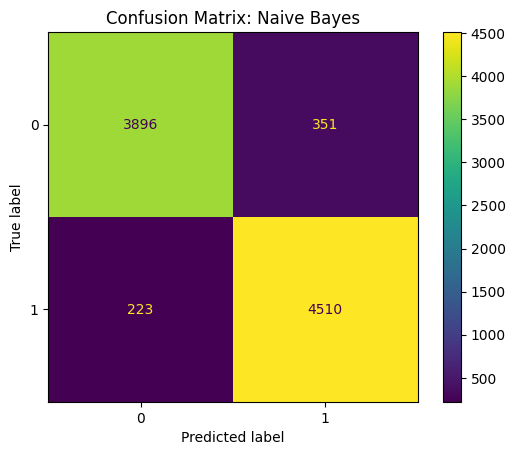

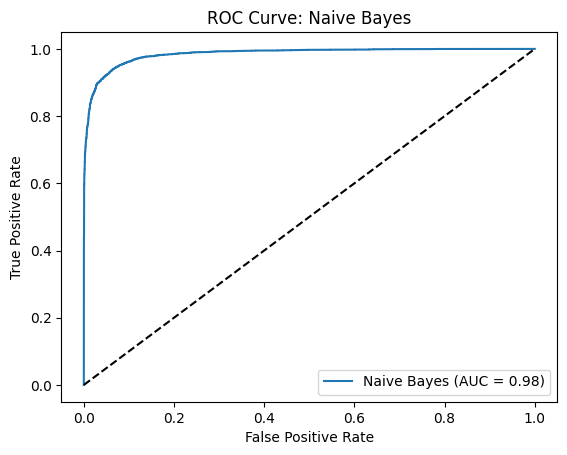

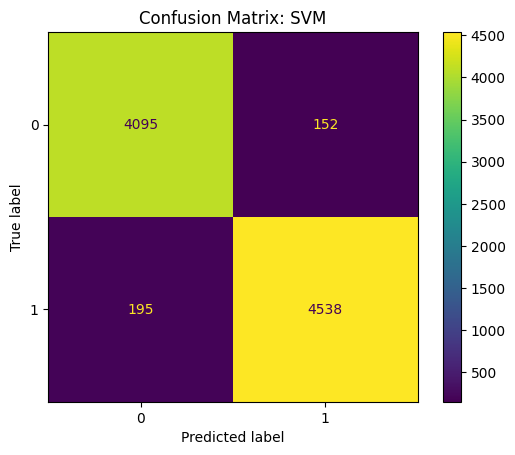

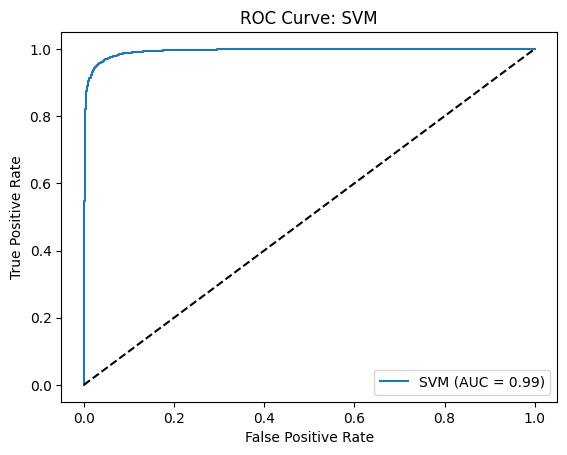

In [18]:
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

def plot_confusion_and_roc(y_true, y_pred, model_name, X_test=None, model=None):
    cm_disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()

    if model and X_test is not None:
        y_scores = model.decision_function(X_test) if hasattr(model, "decision_function") else model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
        plt.plot([0,1], [0,1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve: {model_name}')
        plt.legend(loc='lower right')
        plt.show()

plot_confusion_and_roc(y_test, y_pred_nb, 'Naive Bayes', X_test, nb)
plot_confusion_and_roc(y_test, y_pred_svm, 'SVM', X_test, svm)


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
X_train_raw, X_test_raw, y_train, y_test = train_test_split(df['title'], df['label'], test_size=0.2, random_state=42)

# off-the-shelf pipeline
pipe = make_pipeline(
    TfidfVectorizer(max_features=5000),
    LogisticRegression(max_iter=1000)
)

pipe.fit(X_train_raw, y_train)
print("Off-the-shelf Logistic Regression accuracy:", pipe.score(X_test_raw, y_test))

Off-the-shelf Logistic Regression accuracy: 0.9522271714922049
